In [ ]:
# Install FEniCS
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

## PDE problem ##

Our model problem for time-dependent PDEs reads


\begin{alignat}{2}
{\partial u\over\partial t} &= \nabla.(\kappa \nabla u) + f \quad &&\hbox{in }\Omega\times(0, T], \tag{1}\\
u &= u_D &&\hbox{on } \Gamma_{D},\quad\\
-\kappa{\partial u\over\partial n} &= g(x,y) \quad&&\mbox{on } \Gamma_{N},\quad\\
-\kappa{\partial u\over\partial n} &= h(u - u_0) \quad&&\mbox{on } \Gamma_{R},\quad \tag{2}\\
u &= u_0 &&\mbox{at } t=0. \tag{3}
\end{alignat}
where $\partial \Omega = \Gamma_{D} \cup \Gamma_{N} \cup \Gamma_{R}.$
Here, $u({\bf x},t)$ is space-time-dependent function. The source function $f$ and the
boundary values $u_D$ may also vary with space and time. $T$ is the final time. The initial condition $u_0$ is a function of space only.

### Time-discretization of the heat equation

Let superscript $(n)$ denote a quantity at time $t_n$, where $n$ is an integer counting time levels. For example, $u^{(n)}$ means $u(t_n)$ at time level $n$.

A finite difference discretization in time first consists of sampling the PDE at some time level, say $t_{n+1}$:

\begin{equation}
\left({\partial u \over\partial t}\right)^{(n+1)} = \nabla.(\kappa \nabla u^{(n+1)}) + f^{(n+1)}.  \tag{4}
\end{equation}

The time-derivative can be approximated by a difference quotient.
For simplicity and stability reasons, we choose a
simple **backward Euler method** (or **implicit Euler method**):

\begin{equation}
\left({\partial u\over\partial t}\right)^{(n+1)}\approx {{u^{(n+1)} - u^{(n)}}\over{\Delta t}}, \tag{5}
\end{equation}
where $\Delta t = t_{n+1} - t_n$ is the time discretization parameter. Inserting (5) in (1) yields:

**Semi-discretization of the heat equation:**

\begin{equation}
{{u^{(n+1)} - u^{(n)}}\over{\Delta t}} = \nabla.(\kappa \nabla u^{(n+1)}) + f^{(n+1)}. \tag{6}
\end{equation}

This is our time-discrete version of the heat equation (1), a so-called **backward Euler** or **implicit Euler** discretization.

We may reorder (6) so that the left-hand side contains the terms with the unknown $u^{(n+1)}$ and
the right-hand side contains computed terms only. The result is a sequence of spatial (stationary) problems for $u^{(n+1)}$, assuming $u^{(n)}$ is known from the previous time step:

\begin{align}
u^{(0)} &= u_0,\tag{7a}\\
u^{(n+1)} - {\Delta t}\nabla.(\kappa \nabla u^{(n+1)}) &=  u^{(n)} + {\Delta t} f^{(n+1)},\quad n = 0,1,2,\ldots  \tag{7b}
\end{align}

#### **Algorithm**

Start with $u_0$ and choose a timestep $\Delta t > 0$.

- For n = 0, 1, . . ., solve for $u^{(n+1)}$

\begin{equation}
u^{(n+1)} - {\Delta t}\nabla.(\kappa \nabla u^{(n+1)}) =  u^{(n)} + {\Delta t} f^{(n+1)}. \tag{8}
\end{equation}

At each time step, we use a finite element method to solve (8). This requires turning the equations into weak forms.  As usual, we multiply by a test function $v \in V_0 = \left\{ u \in H^1(\Omega)  | u = 0 \text{ on } \Gamma_D \right\}$:

$$
\int_\Omega u^{(n+1)}v dx  - {\Delta t} \int_\Omega \nabla.(\kappa \nabla u^{(n+1)}) v dx  =  \int_\Omega u^{(n)} v dx  + {\Delta t} \int_\Omega f^{(n+1)} v dx,
$$

and integrate second-derivatives by parts:

$$
 \int_\Omega u^{(n+1)}v dx + {\Delta t} \bigg(\int_\Omega \kappa \nabla u^{(n+1)}\cdot \nabla v dx -
\int_{\partial\Omega}\kappa\frac{\partial u^{(n+1)}}{\partial n}v ds \bigg) = \int_\Omega u^{(n)} v dx  + {\Delta t} \int_\Omega f^{(n+1)} v dx,
$$

Finally by recalling that $ v = 0 $ on $\Gamma_D$ and that $- \kappa \frac{\partial u}{\partial {\bf n} } = g $ on $\Gamma_N$, $- \kappa \frac{\partial u}{\partial {\bf n} } = h(u -u_0 $ on $\Gamma_R$, we obtain:

Inserting the boundary conditions, we obtain:

$$
 \int_\Omega u^{(n+1)}v dx + {\Delta t} \bigg(\int_\Omega \kappa \nabla u^{(n+1)}\cdot \nabla v dx +
\int_{\Gamma_N} gv ds +
\int_{\Gamma_R} h(u -u_0)v ds \bigg) = \int_\Omega u^{(n)} v dx  + {\Delta t} \int_\Omega f^{(n+1)} v dx,
$$

$$
 \int_\Omega u^{(n+1)}v dx + {\Delta t} \int_\Omega \kappa  \nabla u^{(n+1)}\cdot \nabla v dx +
{\Delta t} \int_{\Gamma_R} h u v ds  = \int_\Omega u^{(n)} v dx  + {\Delta t} \int_\Omega f^{(n+1)} v dx -
{\Delta t} \int_{\Gamma_N} g v ds+
{\Delta t} \int_{\Gamma_R} h u_0 v ds.
$$

The resulting weak form arising from formulation (8) can be written in the standard notation:

\begin{equation}
\text{ Find } \quad u = u^{(n+1)} \in   V_{u_D} = \left\{ u \in H^1(\Omega)  | u = u_D \text{ on } \Gamma_D \right\} \text{ such that: }\\
a(u,v)=L_{n+1}(v), \forall v \in V_0,
\end{equation}
where

\begin{align}
a(u,v) &= \int_\Omega\left(uv + {\Delta t}
\kappa  \boldsymbol{\nabla} u\cdot \boldsymbol{\nabla} v  \right)  \mbox{d}x + {\Delta t} \int_{\Gamma_R} h u v  \mbox{d}s,\\
L_{n+1}(v) &= \int_\Omega \left(u^{(n)} + {\Delta t}  f^{(n+1)} \right)v \mbox{d}x -  {\Delta t} \int_{\Gamma_N} g v \mbox{d}s+ {\Delta t} \int_{\Gamma_R} h u_0 \mbox{d}s.
\end{align}

**Example:**

Consider 2D heat transfer across a plate  of thermal conductivity $\kappa = 0.935 W/mC $ shown in the figure below

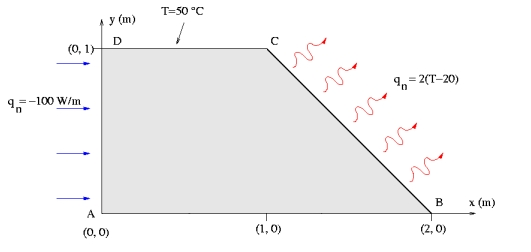

The temperature of the top side of the plate is 50º C and the bottom part is isolated. The heating source is applied at left part of the domain.  Convection constraint is applied at right part of the plate with  heat transfer coefficient of $h = 2 W/m^2ºC$, being $T_0 = 20ºC$ the ambient temperature of the fluid around the plate.

**Solution:**

Governing Equation for Heat Transfer Derived from
Fourier’s law:

\begin{alignat}{2}
{\partial T\over\partial t} &= \nabla.(\kappa \nabla T) + f \quad &&\hbox{in }\Omega\times(0, t_f], \tag{1}
\end{alignat}

We define the heat flux boundary conditions:

\begin{alignat}{2}
-\kappa{\partial T\over\partial n} &= -100 W/m \quad&&\mbox{on } (DA),\quad \tag{2}\\
-\kappa{\partial T\over\partial n} &= 2(T-20) \quad&&\mbox{on } (BC),\quad \tag{3}\\
-\kappa{\partial T\over\partial n} &= 0 \quad&&\mbox{on } (AB),\quad \tag{4}
\end{alignat}

Dirichlet boundary condition:
$$  
T = 50, \quad \mbox{on } (CD),\quad \tag{5}$$
Initial condition:
$$ T = 20, \mbox{  at } t=0. \tag{6}$$



In [ ]:
from dolfin import *
from mshr import *
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

 number of cells =  913


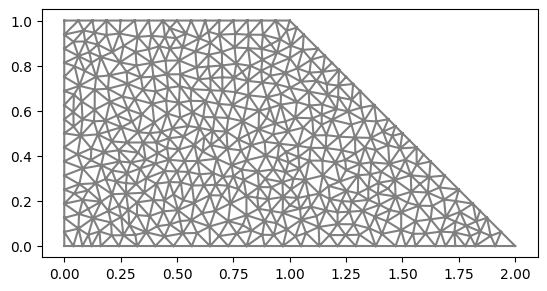

In [ ]:
# Create list of polygonal domain vertices
domain_vertices = [Point(0.0, 0.0),
                   Point(2.0, 0.0),
                   Point(1.0, 1.0),
                   Point(0.0, 1.0),
                   Point(0.0, 0.0)]
#
# Generate mesh and plot
domain = Polygon(domain_vertices)
#
mesh = generate_mesh(domain,20)
#n = 10
#d = 1
#mesh = RectangleMesh(Point(0, 0), Point(1, 1), n, n)
#plot(mesh)

print (" number of cells = ",mesh.num_cells())
plot(mesh)

V = FunctionSpace(mesh, 'P', 1)

In [ ]:
# Set the boundary conditions bc
def top(x, on_boundary):
  return near(x[1],1.0)

u_D = Constant(50.)

bc = DirichletBC(V, u_D, top)

In [ ]:
# Create classes for defining parts of the boundaries and the interior
# of the domain
class Left(SubDomain):
  def inside(self, x, on_boundary):
    return near(x[0], 0.0)

class Right(SubDomain):
  def inside(self, x, on_boundary):
    return near(x[1]+x[0]-2.0, 0.0)

class Bottom(SubDomain):
  def inside(self, x, on_boundary):
    return near(x[1], 0.0)

# Initialize sub-domain instances
left = Left()
right = Right()
bottom = Bottom()

# Initialize mesh function for boundary domains
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)

boundaries.set_all(0)

left.mark(boundaries, 1)
right.mark(boundaries, 3)
bottom.mark(boundaries, 4)

ds=Measure('ds', domain=mesh, subdomain_data=boundaries)

f = Constant(0.)
g1 = Constant(-100.)
g4  = Constant(0.)
h = Constant(2.0)
u_0 = Constant(20.0)
kappa = Constant(0.935)

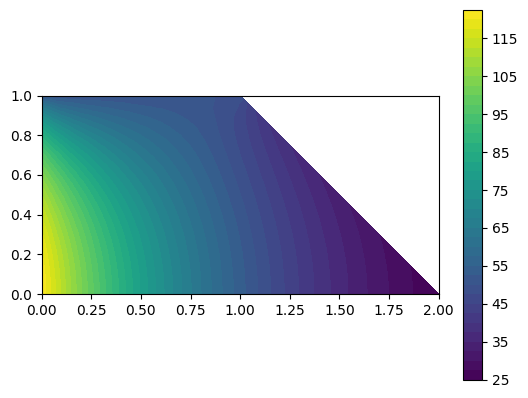

In [ ]:
# Define input data
T = 2.0            # final time
num_steps = 10     # number of time steps
dt = T / num_steps # time step size

T_0 = Constant(20.0)
u_k = interpolate(T_0, V)

u = TrialFunction(V)
v = TestFunction(V)

a = u*v*dx + dt*kappa*dot(grad(u), grad(v))*dx + dt*h*u*v*ds(3)
L =  (u_k + dt*f)*v*dx - dt*g1*v*ds(1) - dt*g4*v*ds(4) + dt*h*u_0*v*ds(3)

uh = Function(V)
t=0

for k in range(num_steps):
  # Update current time
  t += dt
  #u_D.t = t
  #f.t = t ##updating f if f depending on t
  # Solve variational problem
  solve(a==L, uh, bc)
  #FE solution
  vertex_values_u = uh.compute_vertex_values(mesh)
  # Update previous solution
  u_k.assign(uh)

p = plot(u_k)
plt.colorbar(p)

# Adam's script: corrected version

0
1
2
3
4
5
6
7
8
9


/usr/local/lib/python3.10/dist-packages/dolfin/common/plotting.py:152: UserWarning: The following kwargs were not used by contour: 'interactive'
  return ax.tricontourf(mesh2triang(mesh), C, levels, **kwargs)


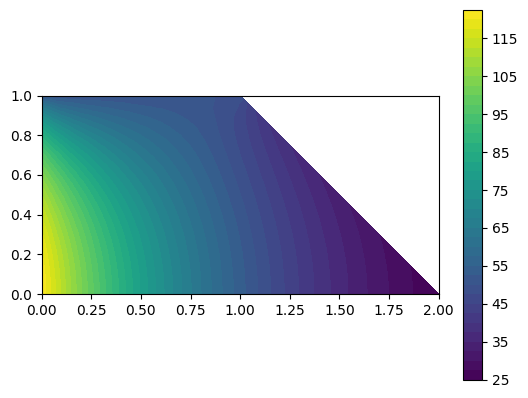

In [ ]:
from dolfin import *
from mshr import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Create list of polygonal domain vertices
domain_vertices = [Point(0.0, 0.0),
                   Point(2.0, 0.0),
                   Point(1.0, 1.0),
                   Point(0.0, 1.0),
                   Point(0.0, 0.0)]
#
# Generate mesh and plot
domain = Polygon(domain_vertices)
#
mesh = generate_mesh(domain,20)
print (" number of cells = ",mesh.num_cells())
#plot(mesh)

V = FunctionSpace(mesh, 'P', 1)

# Boundary conditions
def top(x, on_boundary):
  return near(x[1], 1.0)

u_D = Constant(50.)
bc = DirichletBC(V, u_D, top)

# BC classes
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0)

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1] + x[0] - 2, 0.0)

class Bottom(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0)

# init
left = Left()
right = Right()
bottom = Bottom()

# Initialize mesh function for boundary domains
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)

boundaries.set_all(0)

left.mark(boundaries, 1)
right.mark(boundaries, 3)
bottom.mark(boundaries, 4)

ds=Measure('ds', domain=mesh, subdomain_data=boundaries)

g1 = Constant(-100.)
g4 = Constant(0.)
h = Constant(2.)
u_0 = Constant(20.)
kappa = Constant(0.935)

# Define input data
T = 2.0            # final time
num_steps = 10     # number of time steps
dt = T / num_steps # time step size

f = Expression('0', degree = 3)

u = TrialFunction(V)
v = TestFunction(V)

# Compute and Plot the initial solution
#T_0 = Constant(20.0)
u_k = interpolate(u_0, V)

a = u*v*dx + dt*kappa*dot(grad(u), grad(v))*dx + dt*h*u*v*ds(3)

L =  (u_k + dt*f)*v*dx - dt*g1*v*ds(1) - dt*g4*v*ds(4) + dt*h*u_0*v*ds(3)

u = Function(V)
t = 0

solutions = np.array([])

for k in range(num_steps):

    # Update current time
    t += dt
    u_D.t = t

    # Solve variational problem
    solve(a == L, u, bc)

    # Compute maximum error at vertices

    vertex_values_u = u.compute_vertex_values(mesh)
    np.append(solutions, vertex_values_u)

    # Update previous solution

    u_k.assign(u)

    print(k)
#p = plot(u_k)

p = plot(u, interactive=True)
plt.colorbar(p)

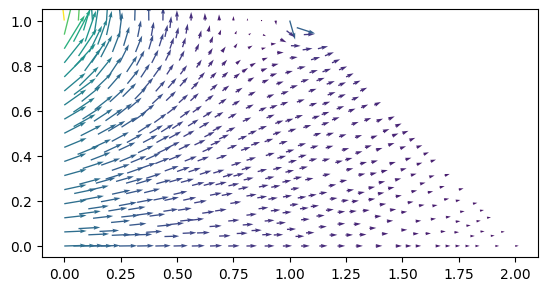

In [ ]:
plot(-kappa*grad(u))